In [1]:
import dask.array as da
import dask.dataframe as dd
import glob
import gzip
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import seaborn as sns
import shutil
from dask.distributed import Client
from dask_ml.model_selection import IncrementalSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from time import sleep

In [2]:
def download_nyc_taxi_data(year, month, output_dir, tag):
    base_url = f'https://github.com/DataTalksClub/nyc-tlc-data/releases/download/{tag}/'
    file_name = f'{tag}_tripdata_{year}-{month:02d}.csv.gz'
    url = base_url + file_name
    
    output_path = os.path.join(output_dir, file_name)
    if os.path.exists(output_path):
        print(f'File already exists: {output_path}')
        return output_path

    for attempt in range(5):
        try:
            response = requests.get(url, stream=True, timeout=10)
            if response.status_code == 200:
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, file_name)
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        f.write(chunk)
                print(f'Downloaded: {file_name}')
                return output_path
            else:
                print(f'Failed to download: {file_name}')
                return None
        except requests.exceptions.RequestException as e:
            print(f'Connection Error: {e}. Attempt {attempt + 1}.')
            sleep(2 ** attempt)

In [3]:
def extract_gz(input_path):
    output_path = input_path.replace('.gz', '')
    with gzip.open(input_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'Extracted: {output_path}')
    return output_path

In [4]:
def csv_to_parquet(input_csv, output_dir, npartitions=4):
    os.makedirs(output_dir, exist_ok=True)

    dtypes = {
        'VendorID': 'float32',
        'passenger_count': 'float32',
        'trip_distance': 'float32',
        'RatecodeID': 'float32',
        'store_and_fwd_flag': 'str',
        'PULocationID': 'float32',
        'DOLocationID': 'float32',
        'payment_type': 'float32',
        'fare_amount': 'float32',
        'extra': 'float32',
        'mta_tax': 'float32',
        'tip_amount': 'float32',
        'tolls_amount': 'float32',
        'improvement_surcharge': 'float32',
        'total_amount': 'float32',
        'congestion_surcharge': 'float32',
    }
    
    if 'green' in os.path.basename(input_csv).lower():
        date_columns = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']

        column_mapping = {
            'lpep_pickup_datetime': 'tpep_pickup_datetime',
            'lpep_dropoff_datetime': 'tpep_dropoff_datetime',
        }
    else:
        date_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
        column_mapping = {}

    ddf = dd.read_csv(
        input_csv,
        dtype=dtypes,
        assume_missing=True,
        parse_dates=date_columns
    )

    if column_mapping:
        ddf = ddf.rename(columns=column_mapping)
        ddf = ddf.drop(columns=['ehail_fee', 'trip_type'], errors='ignore')

    ddf = ddf.repartition(npartitions=npartitions)
    output_path = os.path.join(output_dir, os.path.basename(input_csv).replace('.csv', ''))
    ddf.to_parquet(output_path, engine='pyarrow', write_index=False)
    print(f'Converted to Parquet: {output_path}')
    return output_path

In [5]:
def exploratory_analysis_and_preprocessing(parquet_dir, cleaned_dir):
    parquet_files = glob.glob(os.path.join(parquet_dir, '**', '*.parquet'), recursive=True)
    ddf = dd.read_parquet(parquet_files, engine='pyarrow')

    print('Dataset head:\n', ddf.head())
    print('Dataset info:\n', ddf.info())
    print('Column types:')
    for col in ddf.columns:
        print(f'{col}: {ddf[col].dtype}')

    missing_values = ddf.isnull().sum().compute()
    print('Missing values:\n', missing_values)

    ddf_cleaned = ddf.dropna()
    unique_classes = ddf_cleaned['payment_type'].value_counts().compute()
    valid_payment_types = [int(cls) for cls in unique_classes.index]
    ddf_cleaned = ddf_cleaned[ddf_cleaned['payment_type'].isin(valid_payment_types)]

    os.makedirs(cleaned_dir, exist_ok=True)
    ddf_cleaned.to_parquet(cleaned_dir, engine='pyarrow', write_index=False)
    print(f'Cleaned data saved to: {cleaned_dir}')

In [6]:
def train_ml_model(cleaned_dir, model_dir):
    parquet_files = glob.glob(os.path.join(cleaned_dir, '**', '*.parquet'), recursive=True)
    ddf = dd.read_parquet(parquet_files, engine='pyarrow')

    chunk_size = 100000
    X = ddf[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount']].to_dask_array(lengths=True).rechunk((chunk_size, 4))
    y = ddf['payment_type'].to_dask_array(lengths=True).rechunk(chunk_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SGDClassifier(loss='log_loss', tol=1e-3)
    classes = da.unique(y_train).compute()
    params = {
        'alpha': np.logspace(-4, 1, num=1000),
        'l1_ratio': np.linspace(0, 1, num=1000),
        'average': [True, False],
        'penalty': ['l1', 'l2', 'elasticnet'],
    }

    search = IncrementalSearchCV(
        model,
        params,
        random_state=0,
        n_initial_parameters=1000,
        patience=20,
        max_iter=1000,
        decay_rate=None,
    )
    search.fit(X, y, classes=classes)
    
    print(f'Best Parameters: {search.best_params_}')
    best_model = search.best_estimator_
    accuracy = best_model.score(X_test, y_test)
    print(f'Model accuracy: {accuracy}')
    
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'model_{accuracy}.pkl')
    joblib.dump(best_model, model_path)
    print(f'Model saved to: {model_path}')

    return model_path, X_test, y_test

In [21]:
def evaluate_model(model_path, X_test, y_test):
    model = joblib.load(model_path)
    y_pred = model.predict(X_test)
    unique_classes = sorted(da.unique(y_test).compute())
    target_names = [f'Type {int(cls)}' for cls in unique_classes]

    report = classification_report(y_test.compute(), y_pred, target_names=target_names)
    print('Classification Report:\n', report)

    cm = confusion_matrix(y_test.compute(), y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalised)')
    plt.show()

In [8]:
output_dir = './data'
parquet_dir = os.path.join(output_dir, 'parquet')
cleaned_dir = os.path.join(parquet_dir, 'cleaned')
model_dir = os.path.join(cleaned_dir, 'model')

In [9]:
client = Client(n_workers=12, threads_per_worker=2, memory_limit='24GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 24,Total memory: 268.22 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59646,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 268.22 GiB
Comm: tcp://127.0.0.1:59715,Total threads: 2
Dashboard: http://127.0.0.1:59724/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:59649,


In [10]:
years = [2019, 2020, 2021]
months = [i + 1 for i in range(12)]
tags = ['yellow', 'green']

for year in years:
    for month in months:
        for tag in tags:
            gz_path = download_nyc_taxi_data(year, month, output_dir, tag)
            if gz_path:
                extract_gz(gz_path)
            if year == 2021 and month == 7:
                break

Downloaded: yellow_tripdata_2019-01.csv.gz
Extracted: ./data\yellow_tripdata_2019-01.csv
Downloaded: green_tripdata_2019-01.csv.gz
Extracted: ./data\green_tripdata_2019-01.csv
Downloaded: yellow_tripdata_2019-02.csv.gz
Extracted: ./data\yellow_tripdata_2019-02.csv
Downloaded: green_tripdata_2019-02.csv.gz
Extracted: ./data\green_tripdata_2019-02.csv
Downloaded: yellow_tripdata_2019-03.csv.gz
Extracted: ./data\yellow_tripdata_2019-03.csv
Downloaded: green_tripdata_2019-03.csv.gz
Extracted: ./data\green_tripdata_2019-03.csv
Downloaded: yellow_tripdata_2019-04.csv.gz
Extracted: ./data\yellow_tripdata_2019-04.csv
Downloaded: green_tripdata_2019-04.csv.gz
Extracted: ./data\green_tripdata_2019-04.csv
Downloaded: yellow_tripdata_2019-05.csv.gz
Extracted: ./data\yellow_tripdata_2019-05.csv
Downloaded: green_tripdata_2019-05.csv.gz
Extracted: ./data\green_tripdata_2019-05.csv
Downloaded: yellow_tripdata_2019-06.csv.gz
Extracted: ./data\yellow_tripdata_2019-06.csv
Downloaded: green_tripdata_2019

In [11]:
csv_files = glob.glob(os.path.join(output_dir, '*.csv'))
for csv_file in csv_files:
    csv_to_parquet(csv_file, parquet_dir, npartitions=16)

Converted to Parquet: ./data\parquet\green_tripdata_2019-01
Converted to Parquet: ./data\parquet\green_tripdata_2019-02
Converted to Parquet: ./data\parquet\green_tripdata_2019-03
Converted to Parquet: ./data\parquet\green_tripdata_2019-04
Converted to Parquet: ./data\parquet\green_tripdata_2019-05
Converted to Parquet: ./data\parquet\green_tripdata_2019-06
Converted to Parquet: ./data\parquet\green_tripdata_2019-07
Converted to Parquet: ./data\parquet\green_tripdata_2019-08
Converted to Parquet: ./data\parquet\green_tripdata_2019-09
Converted to Parquet: ./data\parquet\green_tripdata_2019-10
Converted to Parquet: ./data\parquet\green_tripdata_2019-11
Converted to Parquet: ./data\parquet\green_tripdata_2019-12
Converted to Parquet: ./data\parquet\green_tripdata_2020-01
Converted to Parquet: ./data\parquet\green_tripdata_2020-02
Converted to Parquet: ./data\parquet\green_tripdata_2020-03
Converted to Parquet: ./data\parquet\green_tripdata_2020-04
Converted to Parquet: ./data\parquet\gre

In [12]:
exploratory_analysis_and_preprocessing(parquet_dir, cleaned_dir)

Dataset head:
    VendorID tpep_pickup_datetime tpep_dropoff_datetime store_and_fwd_flag  \
0       2.0  2018-12-21 15:17:29   2018-12-21 15:18:57                  N   
1       2.0  2019-01-01 00:10:16   2019-01-01 00:16:32                  N   
2       2.0  2019-01-01 00:27:11   2019-01-01 00:31:38                  N   
3       2.0  2019-01-01 00:46:20   2019-01-01 01:04:54                  N   
4       2.0  2019-01-01 00:19:06   2019-01-01 00:39:43                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0         264.0         264.0              5.0           0.00   
1         1.0          97.0          49.0              2.0           0.86   
2         1.0          49.0         189.0              2.0           0.66   
3         1.0         189.0          17.0              2.0           2.68   
4         1.0          82.0         258.0              1.0           4.53   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \

In [13]:
model_path, X_test, y_test = train_ml_model(cleaned_dir, model_dir)

Best Parameters: {'penalty': 'l1', 'l1_ratio': np.float64(0.017017017017017015), 'average': True, 'alpha': np.float64(0.0001699144172034626)}
Model accuracy: 0.9558408028177224
Model saved to: ./data\parquet\cleaned\model\model_0.9558408028177224.pkl


Classification Report:
               precision    recall  f1-score   support

      Type 1       1.00      0.95      0.97  17814702
      Type 2       0.86      1.00      0.93   6752999
      Type 3       0.13      0.00      0.01    137464
      Type 4       0.45      0.32      0.37     67123
      Type 5       0.00      0.00      0.00        60

    accuracy                           0.96  24772348
   macro avg       0.49      0.45      0.46  24772348
weighted avg       0.96      0.96      0.95  24772348



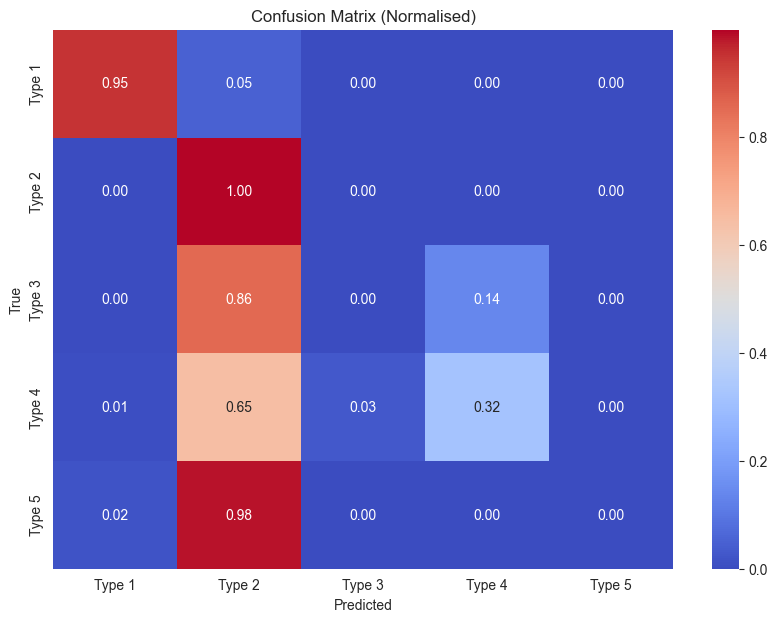

In [22]:
evaluate_model(model_path, X_test, y_test)